In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip 
!unzip bank.zip

--2024-10-20 22:01:06--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999.85K   939KB/s    in 1.1s    

2024-10-20 22:01:08 (939 KB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [1]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt


bank_subscription_df = pd.read_csv('../../data/04-week/bank-full.csv',delimiter=';')

In [2]:
from sklearn.metrics import roc_curve,auc

In [3]:
required_cols = ['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

bank_subscription_df = bank_subscription_df[required_cols]

In [4]:
bank_subscription_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [5]:
bank_subscription_df.columns = bank_subscription_df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(bank_subscription_df.dtypes[bank_subscription_df.dtypes == 'object'].index)

for c in categorical_columns:
    bank_subscription_df[c] = bank_subscription_df[c].str.lower().str.replace(' ', '_')


bank_subscription_df.y = (bank_subscription_df.y == 'yes').astype(int)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
bank_subscription_full_train, bank_subscription_test = train_test_split(bank_subscription_df,test_size=0.2,random_state=1)
bank_subscription_train,bank_subscription_val = train_test_split(bank_subscription_full_train,test_size=0.25,random_state=1)

In [8]:
bank_subscription_train = bank_subscription_train.reset_index(drop=True)
bank_subscription_val = bank_subscription_val.reset_index(drop=True)
bank_subscription_test = bank_subscription_test.reset_index(drop=True)


y_train = bank_subscription_train.y.values
y_val = bank_subscription_val.y.values
y_test = bank_subscription_test.y.values

bank_subscription_train.drop('y',axis = 1,inplace=True)
bank_subscription_val.drop('y',axis = 1,inplace=True)
bank_subscription_test.drop('y',axis = 1,inplace=True)


### Question 1: ROC AUC feature importance



In [9]:
numerical_val = ['age','balance','day','duration','campaign','pdays','previous']
categorial_val = ['job','marital','education','housing','contact','month','poutcome']

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
auc_val = dict()
for value in numerical_val:
    print(value)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000,)
    
    X_train = bank_subscription_train[[value]].values
    if value == 'age':
        X_train = -bank_subscription_train[[value]].values
    model.fit(X_train,y_train)
    y_pred = model.predict_proba(X_train)[:, 1]
    churn_decision = (y_pred >= 0.5)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    auc_val[value] = auc(fpr, tpr)
    
    

age
balance
day
duration
campaign
pdays
previous


In [12]:
[k for k,v in auc_val.items() if v < 0.5]

['age']

In [13]:
auc_val

{'age': 0.48781428247265596,
 'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'campaign': 0.5714543015682159,
 'pdays': 0.5901276247352144,
 'previous': 0.5985653242764153}

### Question 2: Training the model

In [14]:
train_dict = bank_subscription_train[numerical_val+categorial_val].to_dict(orient='records')
val_dict = bank_subscription_val[numerical_val+categorial_val].to_dict(orient='records')

In [15]:
from sklearn.feature_extraction import DictVectorizer

In [16]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

X_val = dv.transform(val_dict)

In [19]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)
y_pred = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
np.round(auc(fpr, tpr),5)

0.89997

### Question 3: Precision and Recall



In [20]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp/ (tp + fn)
    F1_score = 2 * precision * recall / (precision + recall)

    
    scores.append((t, tp, fp, fn, tn,precision,recall,F1_score))


/var/folders/hh/8c9bdtz97vs7pb_m1p4ff4wm0000gn/T/ipykernel_10830/3845135365.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [21]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall','F1_score']
df_scores = pd.DataFrame(scores, columns=columns)


In [22]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall,F1_score
0,0.00,1098,7944,0,0,0.121433,1.000000,0.216568
1,0.01,1094,6956,4,988,0.135901,0.996357,0.239178
2,0.02,1093,5768,5,2176,0.159306,0.995446,0.274658
3,0.03,1086,4738,12,3206,0.186470,0.989071,0.313782
4,0.04,1067,3778,31,4166,0.220227,0.971767,0.359078
...,...,...,...,...,...,...,...,...
96,0.96,32,17,1066,7927,0.653061,0.029144,0.055798
97,0.97,25,15,1073,7929,0.625000,0.022769,0.043937
98,0.98,22,10,1076,7934,0.687500,0.020036,0.038938
99,0.99,10,6,1088,7938,0.625000,0.009107,0.017953


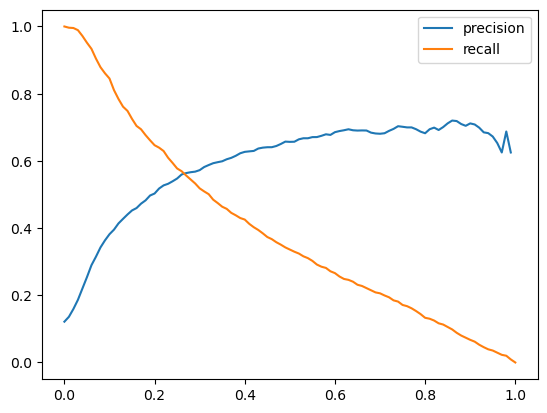

In [23]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

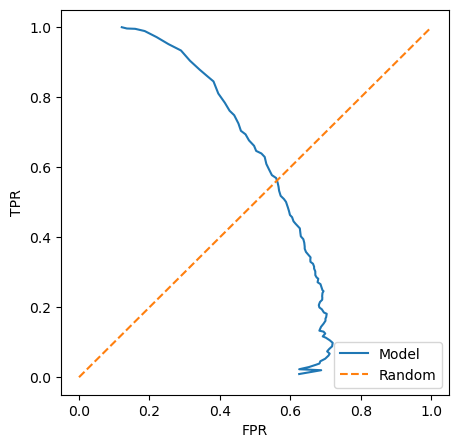

In [25]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.precision, df_scores.recall, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### Question 4: F1 score


In [26]:
df_scores[df_scores['F1_score'].max()==df_scores['F1_score']]

,threshold,tp,fp,fn,tn,precision,recall,F1_score
22,0.22,691,620,407,7324,0.527079,0.629326,0.573682


### Question 5: 5-Fold CV

In [27]:
from sklearn.model_selection import KFold

In [28]:
from sklearn.metrics import roc_auc_score


In [29]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorial_val + numerical_val].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [30]:
def predict(df, dv, model):
    dicts = df[categorial_val + numerical_val].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [31]:

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(bank_subscription_full_train):
    df_train = bank_subscription_full_train.iloc[train_idx]
    df_val = bank_subscription_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [34]:
np.round(np.std(scores),3)

0.006

In [33]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(bank_subscription_full_train):
        df_train = bank_subscription_full_train.iloc[train_idx]
        df_val = bank_subscription_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
